## 说明
1. 文件《embeding\text_embeddings_clean.npy》是韩国小姑娘用《embedding+theme analysis.ipynb》生成的  
- 输入文件是github上《results\act3301_processed_data.csv》，
- 删除letter列为空的行，然后对letter列每一行做embedding得到的结果
- 与之每行对应的csv文件是github上《results\act3301_processed_data_clean.csv》，但是<font color=red>小姑娘遗漏上传了</font>。

2. 为了解决<font color=red>小姑娘遗漏上传</font>问题，我使用我的《embedding_l2.ipynb》脚本来生成相关文件，有如下特点  
- 由于韩国小姑娘的代码中， 加大 max_length=512 值就会报错，我没有能力修改小姑娘的代码搞定这个问题。于是使用官方的 SentenceTransformer 函数来达到同样生成embedding的目的，且设置了加大的 max_length=2048 值。- 
max_length=2048 这个参数告诉 SBERT 分析输入文本的前2048个token, 超出的tokens会被截断丢弃，不做分析
- 文件act3301_processed_data_clean.csv保存在 r"V:\20240920\theme_analysis_act3301\act3301_processed_data_clean.csv"
- embedding保存在r"V:\20240920\theme_analysis_act3301\text_embeddings_clean_lb2.npy"

3. 在《embedding_l2.ipynb》脚本存在v1和v2版输入输出文件，v2要更优化一点。如果要使用v2，需要注意修改本脚本的输入文件。


# PCA

## explain variance percentage

In [5]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def components_for_variance(embeddings_path, n):
    embed = np.load(embeddings_path)
    scaler = StandardScaler()
    scaled_embeddings = scaler.fit_transform(embed)

    pca = PCA()
    pca.fit(scaled_embeddings)
    
    # Calculate cumulative variance ratio
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    
    num_components = np.argmax(cumulative_variance >= n) + 1  
    
    print(f"Need {num_components} components to explain {n * 100}% variance.")
    return num_components


embeddings_path = r"V:\20240920\theme_analysis_act3301\text_embeddings_clean_lb2.npy"

components_for_variance(embeddings_path, 0.7)
components_for_variance(embeddings_path, 0.8)
components_for_variance(embeddings_path, 0.9)


Need 34 components to explain 70.0% variance.
Need 63 components to explain 80.0% variance.
Need 135 components to explain 90.0% variance.


135

## Scree plot & Cumulative variance plot

Loading embeddings...
Standardizing embeddings...
Applying PCA with 63 components...
Total explained variance: 0.8001


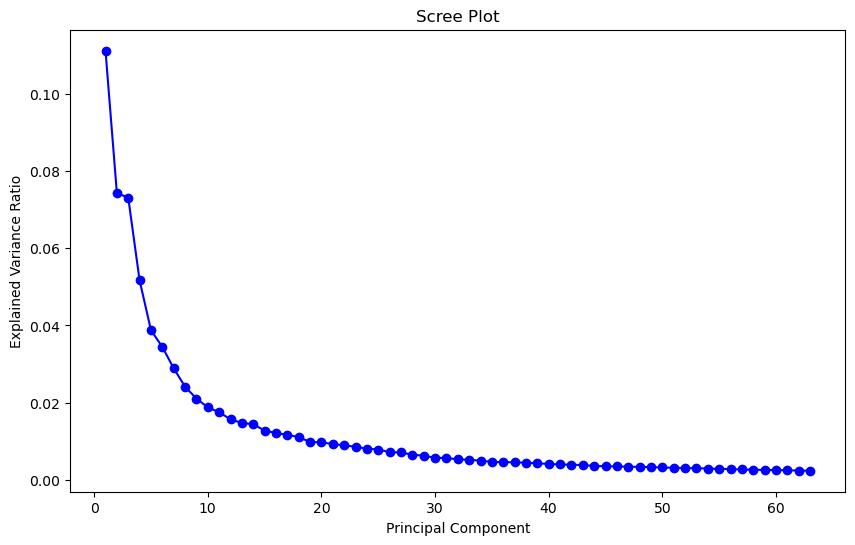

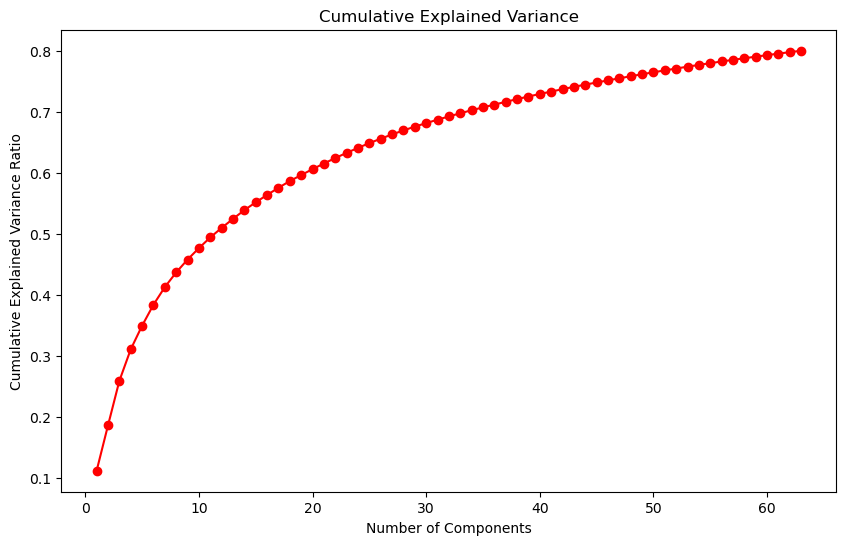


PCA results shape: (5586, 63)


In [6]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

def apply_pca_analysis(embeddings_path=r"V:\20240920\theme_analysis_act3301\text_embeddings_clean_lb2.npy", n_components=135):
   # Load embeddings
   print("Loading embeddings...")
   embeddings = np.load(embeddings_path)
   
   # Standardize the embeddings
   print("Standardizing embeddings...")
   scaler = StandardScaler()
   scaled_embeddings = scaler.fit_transform(embeddings)
   
   # Apply PCA
   print(f"Applying PCA with {n_components} components...")
   pca = PCA(n_components=n_components)
   pca_result = pca.fit_transform(scaled_embeddings)
   
   # Calculate explained variance
   # print("\nExplained variance ratio:")
   # for i, ratio in enumerate(pca.explained_variance_ratio_):
   #     print(f"Component {i+1}: {ratio:.4f}")
   print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.4f}")
   
   # Plotting
   # 1. Scree plot
   plt.figure(figsize=(10, 6))
   plt.plot(range(1, n_components + 1), 
            pca.explained_variance_ratio_, 'bo-')
   plt.title('Scree Plot')
   plt.xlabel('Principal Component')
   plt.ylabel('Explained Variance Ratio')
   plt.show()
   
   # 2. Cumulative variance plot
   plt.figure(figsize=(10, 6))
   plt.plot(range(1, n_components + 1), 
            np.cumsum(pca.explained_variance_ratio_), 'ro-')
   plt.title('Cumulative Explained Variance')
   plt.xlabel('Number of Components')
   plt.ylabel('Cumulative Explained Variance Ratio')
   plt.show()
   
   return pca_result, pca

if __name__ == "__main__":
   # Apply PCA
   pca_result, pca = apply_pca_analysis(n_components = 63)
   
   # Save PCA results
   np.save(r"V:\20240920\theme_analysis_act3301\pca_results.npy", pca_result)
   
   print("\nPCA results shape:", pca_result.shape)
   # print("\nFirst few transformed samples:")
   # print(pca_result[:1])

## Number of Components vs. Cumulative Explained Variance

Optimal number of components to explain 80.0% of variance: 63


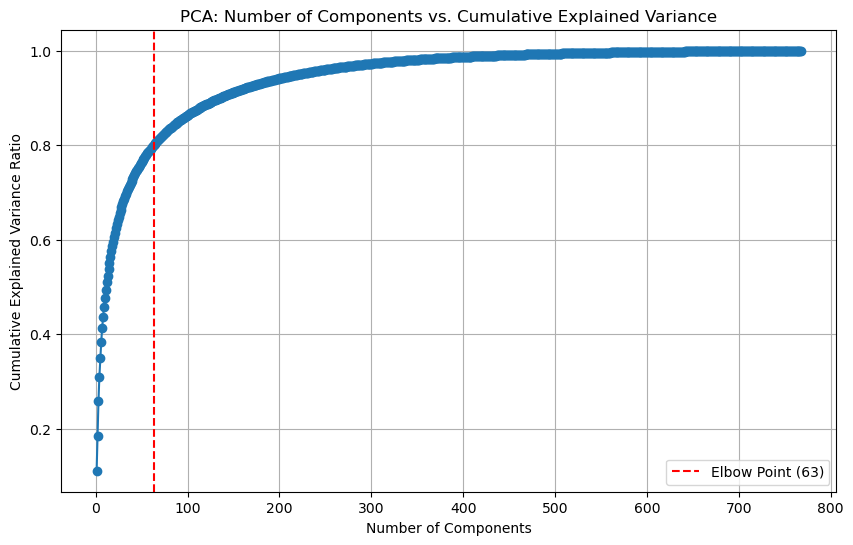

In [7]:
# Applying the Elbow Method

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


embeddings_path = r"V:\20240920\theme_analysis_act3301\text_embeddings_clean_lb2.npy"
embed = np.load(embeddings_path)
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(embed)

pca = PCA()
pca.fit(scaled_embeddings)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

threshold = 0.80
optimal_components = np.argmax(cumulative_variance >= threshold) + 1
print(f"Optimal number of components to explain {threshold * 100}% of variance: {optimal_components}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.axvline(optimal_components, color='r', linestyle='--', label=f'Elbow Point ({optimal_components})')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA: Number of Components vs. Cumulative Explained Variance')
plt.legend()
plt.grid(True)
plt.show()

## Themes analysis

In [68]:
import numpy as np
import os
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def analyze_pca_themes(embeddings_path=r"V:\20240920\theme_analysis_act3301\text_embeddings_clean_lb2.npy", 
                       data_path=r"V:\20240920\theme_analysis_act3301\act3301_processed_data_clean.csv",
                       n_components=34, 
                       n_top_texts=5):
    # Load data
    print("Loading data...")
    embeddings = np.load(embeddings_path)
    df = pd.read_csv(data_path)

    # compare length of embedding and data file 
    print("\n --- compare length of embedding and data file ---")
    print(f"Embeddings shape: {embeddings.shape}")
    print(f"length of data file: {len(df['letter'])}")
    
    # Check data length consistency
    if embeddings.shape[0] != len(df):
        raise ValueError("The number of embeddings does not match the number of texts in the data file.")
    
    # Compare length of embedding and data file 
    print("\n --- Compare length of embedding and data file ---")
    print(f"Embeddings shape: {embeddings.shape}")
    print(f"Length of data file: {len(df['letter'])}")
    
    # Standardize embeddings
    print("\n--- Standardizing embeddings...")
    scaler = StandardScaler()
    scaled_embeddings = scaler.fit_transform(embeddings)
   
    # Apply PCA
    print(f"\n--- Applying PCA with {n_components} components...")
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(scaled_embeddings)
   
    print(f"\n --- Total explained variance: {sum(pca.explained_variance_ratio_):.4f}")
    
    # Print explained variance ratio per component
    print("\n--- Explained Variance Ratio per Component ---")
    for i, ratio in enumerate(pca.explained_variance_ratio_):
        print(f"Component {i+1}: {ratio:.4f}")
   
    # Analyze themes
    print("\n\n --- Analyzing themes in each component...")
    themes = {}
    for i in range(n_components):
        # Get component scores
        scores = pca_result[:, i]
        
        # Get top and bottom texts
        top_indices = np.argsort(scores)[-n_top_texts:]
        bottom_indices = np.argsort(scores)[:n_top_texts]
        
        # Add statistics
        themes[f'Component_{i+1}'] = {
            'positive': [(df['letter'].iloc[idx], scores[idx]) 
                         for idx in reversed(top_indices)],
            'negative': [(df['letter'].iloc[idx], scores[idx]) 
                         for idx in bottom_indices],
            'score_stats': {
                'mean': np.mean(scores),
                'std': np.std(scores),
                'min': np.min(scores),
                'max': np.max(scores)
            }
        }
   
    return pca_result, themes

def save_themes_to_excel(themes, output_path):
    """
    Save the thematic analysis results to an Excel file.
    """
    # Step 1: Check if the file exists and delete it
    if os.path.exists(output_path):
        os.remove(output_path)
        print(f"File '{output_path}' has been deleted.")
    else:
        print(f"File '{output_path}' does not exist. Creating a new file.")
    
    # Create a Pandas Excel writer using XlsxWriter as the engine
    with pd.ExcelWriter(output_path, engine='xlsxwriter') as writer:
        for component, theme_data in themes.items():
            # Create a DataFrame for positive examples
            positive_df = pd.DataFrame(theme_data['positive'], columns=['Text', 'Score'])
            positive_df.to_excel(writer, sheet_name=f"{component}_Positive", index=False)
            
            # Create a DataFrame for negative examples
            negative_df = pd.DataFrame(theme_data['negative'], columns=['Text', 'Score'])
            negative_df.to_excel(writer, sheet_name=f"{component}_Negative", index=False)
            
            # Add statistics to the Excel file
            stats_df = pd.DataFrame([theme_data['score_stats']])
            stats_df.to_excel(writer, sheet_name=f"{component}_Stats", index=False)

if __name__ == "__main__":
    # Apply PCA and analyze themes
    pca_result, themes = analyze_pca_themes()
    
    # Save PCA results
    np.save(r"V:\20240920\theme_analysis_act3301\pca_results.npy", pca_result)
    
    # Save themes to Excel file
    save_themes_to_excel(themes, r"V:\20240920\theme_analysis_act3301\thematic_analysis_results.xlsx")

Loading data...

 --- compare length of embedding and data file ---
Embeddings shape: (5586, 768)
length of data file: 5586

 --- Compare length of embedding and data file ---
Embeddings shape: (5586, 768)
Length of data file: 5586

--- Standardizing embeddings...

--- Applying PCA with 34 components...

 --- Total explained variance: 0.7025

--- Explained Variance Ratio per Component ---
Component 1: 0.1112
Component 2: 0.0743
Component 3: 0.0731
Component 4: 0.0517
Component 5: 0.0388
Component 6: 0.0344
Component 7: 0.0289
Component 8: 0.0241
Component 9: 0.0211
Component 10: 0.0188
Component 11: 0.0175
Component 12: 0.0157
Component 13: 0.0147
Component 14: 0.0144
Component 15: 0.0128
Component 16: 0.0121
Component 17: 0.0117
Component 18: 0.0111
Component 19: 0.0098
Component 20: 0.0097
Component 21: 0.0093
Component 22: 0.0089
Component 23: 0.0086
Component 24: 0.0081
Component 25: 0.0079
Component 26: 0.0072
Component 27: 0.0071
Component 28: 0.0065
Component 29: 0.0063
Componen

## Varimax Rotation

In [61]:
from factor_analyzer.rotator import Rotator

# load data
embeddings_path=r"V:\20240920\theme_analysis_act3301\text_embeddings_clean_lb2.npy"
embeddings = np.load(embeddings_path)

# Standardize embeddings
print("Standardizing embeddings...")
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(embeddings)

# 90% varianc explanation.
pca = PCA()
pca_result = pca.fit_transform(scaled_embeddings)
cumulative_variance = pca.explained_variance_ratio_.cumsum()
threshold = 0.4
n_components = np.argmax(cumulative_variance >= threshold) + 1
pca = PCA(n_components=n_components)
pca.fit(scaled_embeddings)

# transposes the matrix so that each row corresponds to a feature and each column corresponds to a component.
loadings = pca.components_.T  
print("\n---Loadings:\n", loadings)
print(loadings.shape)
print(loadings.T.shape)

rotator = Rotator(method='varimax')
rotated_loadings = rotator.fit_transform(loadings)

print("\n---Rotated Loadings:\n", rotated_loadings)
print(f"Rotated Loadings's shape: {rotated_loadings.shape}")
print(pca.components_.shape)
print(pca.components_.T.shape)

Standardizing embeddings...

---Loadings:
 [[ 0.0629569   0.02778448  0.03001854 ... -0.01600833  0.00058399
  -0.03247165]
 [ 0.03351092 -0.00943193  0.04230374 ...  0.04218781 -0.01660051
  -0.02001484]
 [ 0.00152527  0.02726353 -0.01039413 ...  0.06056885 -0.06250619
  -0.03448356]
 ...
 [ 0.07952642  0.00083973  0.0048532  ... -0.00224033 -0.02583385
   0.00579197]
 [ 0.07967237 -0.02608951  0.01103603 ... -0.00033203 -0.0023004
   0.04720537]
 [-0.02355921 -0.01462153 -0.07652304 ... -0.05912568 -0.04923505
  -0.05739063]]
(768, 7)
(7, 768)

---Rotated Loadings:
 [[ 0.04830036  0.0531606  -0.01664799 ...  0.01726328 -0.00035194
  -0.02212779]
 [ 0.01898619  0.02307454  0.02677189 ...  0.06409739 -0.04437367
   0.01699906]
 [-0.04129681  0.02000996  0.00465672 ...  0.02711204 -0.08330863
   0.00886791]
 ...
 [ 0.04234261  0.04376721 -0.01555056 ...  0.00235776  0.00306726
   0.0361083 ]
 [ 0.0374586   0.04634333  0.00852692 ...  0.02752875  0.01832097
   0.07664455]
 [-0.00648749 -

### get the new score after varimax rotation?

In [62]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from factor_analyzer.rotator import Rotator

# Step 1: Load the Data
embeddings_path = r"V:\20240920\theme_analysis_act3301\text_embeddings_clean_lb2.npy"
data_path = r"V:\20240920\theme_analysis_act3301\act3301_processed_data_clean.csv"

embeddings = np.load(embeddings_path)
df = pd.read_csv(data_path)

# Step 2: Standardize the Embeddings
print("Standardizing embeddings...")
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(embeddings)

# Step 3: Perform PCA and Varimax Rotation
# Perform PCA to determine the number of components explaining 90% variance
pca = PCA()
pca_result = pca.fit_transform(scaled_embeddings)
cumulative_variance = pca.explained_variance_ratio_.cumsum()
threshold = 0.9
n_components = np.argmax(cumulative_variance >= threshold) + 1

# Fit PCA with the selected number of components
pca = PCA(n_components=n_components)
pca.fit(scaled_embeddings)

# Extract PCA loadings and transpose them
loadings = pca.components_.T

# Apply Varimax rotation
rotator = Rotator(method='varimax')
rotated_loadings = rotator.fit_transform(loadings)

# Step 4: Project Data onto Rotated Components
# Calculate the new scores by multiplying the standardized embeddings with the rotated loadings
rotated_scores = np.dot(scaled_embeddings, rotated_loadings)

# Step 5: Save the New Scores
# Save the rotated scores to a new file
output_path = r"V:\20240920\theme_analysis_act3301\rotated_scores.npy"
np.save(output_path, rotated_scores)

# Print the shape of the rotated scores
print(f"Rotated Scores' shape: {rotated_scores.shape}")

# Optional: Save the rotated scores with corresponding text data to a CSV file
rotated_scores_df = pd.DataFrame(rotated_scores, columns=[f"Rotated_Component_{i+1}" for i in range(n_components)])
rotated_scores_df["letter"] = df["letter"].values
rotated_scores_df.to_csv(r"V:\20240920\theme_analysis_act3301\rotated_scores_with_text.csv", index=False)

Standardizing embeddings...
Rotated Scores' shape: (5586, 135)


### get top_n positive and negative score letter of each Rotated Component 

In [66]:
import pandas as pd

# Define the number of top scores to extract
top_n = 5

# Step 1: Load the Data
# Assuming rotated_scores_df is already created (from the previous code)
# rotated_scores_df = pd.DataFrame(rotated_scores, columns=[f"Rotated_Component_{i+1}" for i in range(n_components)])
# rotated_scores_df["letter"] = df["letter"].values

# Step 2: Extract Top `top_n` Positive and Negative Scores for Each Rotated Component
results = []
for component in rotated_scores_df.columns[:-1]:  # Exclude the "letter" column
    # Get the top_n positive scores
    top_positive = rotated_scores_df.nlargest(top_n, component)[["letter", component]]
    
    # Get the top_n negative scores
    top_negative = rotated_scores_df.nsmallest(top_n, component)[["letter", component]]
    
    # Store the results for positive scores
    for letter, score in top_positive.values:
        results.append({
            "Component": component,
            "Type": "Positive",
            "Letter": letter,
            "Score": score
        })
    
    # Store the results for negative scores
    for letter, score in top_negative.values:
        results.append({
            "Component": component,
            "Type": "Negative",
            "Letter": letter,
            "Score": score
        })

# Step 3: Save the Results to a CSV File
# Create a DataFrame to store the results
results_df = pd.DataFrame(results)

# Save the results to a CSV file
output_path = r"V:\20240920\theme_analysis_act3301\top_scores_per_rotated_component.csv"
results_df.to_csv(output_path, index=False)

# Print the results
print(results_df)

                  Component      Type  \
0       Rotated_Component_1  Positive   
1       Rotated_Component_1  Positive   
2       Rotated_Component_1  Positive   
3       Rotated_Component_1  Positive   
4       Rotated_Component_1  Positive   
...                     ...       ...   
1345  Rotated_Component_135  Negative   
1346  Rotated_Component_135  Negative   
1347  Rotated_Component_135  Negative   
1348  Rotated_Component_135  Negative   
1349  Rotated_Component_135  Negative   

                                                 Letter      Score  
0     as a woman and a mother, i can see the importa...  12.639822  
1     women can run business and be bosses. decades ...  12.565408  
2     how can anyone who needs so much extra help be...  12.478990  
3     why can't we just hire the best person for the...  11.854223  
4     i think if a person man or women have worked t...  11.853843  
...                                                 ...        ...  
1345  segregation ended 

# test tips